In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/household-powerconsumption/household_power_consumption.csv


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# 1) Load the entire dataset
path = "/kaggle/input/household-powerconsumption/household_power_consumption.csv"
df = pd.read_csv(path, sep=',', na_values='?')


# 2) Drop the 'index' column 
if 'index' in df.columns:
    df.drop(columns=['index'], inplace=True)

# 3) Strip whitespace from column names 
df.columns = df.columns.str.strip()

# 4) Combine Date & Time into a single Datetime index
df['Datetime'] = pd.to_datetime(
    df['Date'].str.strip() + ' ' + df['Time'].str.strip(),
    format='%d/%m/%y %H:%M:%S',
    dayfirst=True,
    errors='coerce'
)
df.dropna(subset=['Datetime'], inplace=True)
df.set_index('Datetime', inplace=True)
df.drop(columns=['Date', 'Time'], inplace=True)

# 5) Convert measurement columns to numeric, drop any rows with NaNs
numeric_cols = [
    'Global_active_power','Global_reactive_power','Voltage',
    'Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3'
]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(subset=numeric_cols, inplace=True)

# 6) Exploratory Data Analysis
#   a) Quick summary statistics
print("=== Summary Statistics ===")
print(df[numeric_cols].describe(), "\n")


=== Summary Statistics ===
       Global_active_power  Global_reactive_power        Voltage  \
count        103640.000000          103640.000000  103640.000000   
mean              1.204582               0.125108     239.056833   
std               1.184427               0.112474       3.658287   
min               0.096000               0.000000     224.620000   
25%               0.308000               0.000000     236.350000   
50%               0.672000               0.106000     239.530000   
75%               1.666000               0.194000     241.810000   
max              10.670000               0.986000     250.020000   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count     103640.000000   103640.000000   103640.000000   103640.000000  
mean           5.138283        1.281455        1.692956        6.066316  
std            5.007758        6.551113        6.825293        8.260284  
min            0.400000        0.000000        0.000000        0

In [6]:
#   b) Missing-value check
print("=== Missing Values (should be zero as we already handled them) ===")
print(df[numeric_cols].isna().sum(), "\n")

=== Missing Values (should be zero as we already handled them) ===
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64 



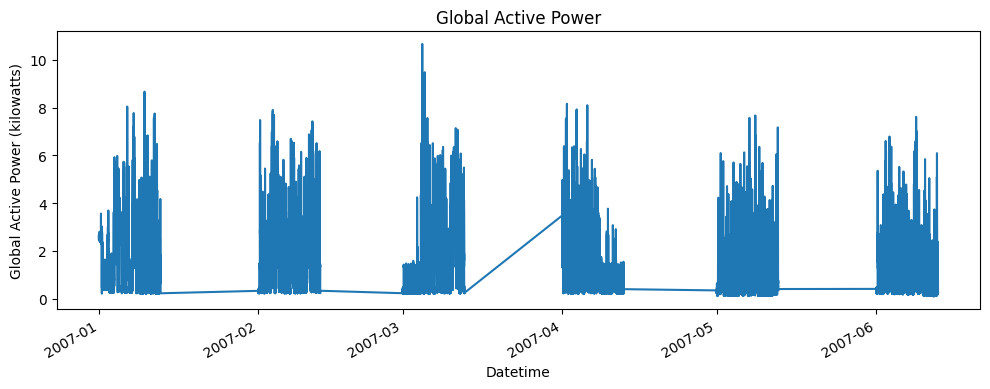

In [7]:
#   c) Time series plot of Global_active_power
plt.figure(figsize=(10, 4))
df['Global_active_power'].plot(title='Global Active Power')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kilowatts)')
plt.tight_layout()
plt.show()

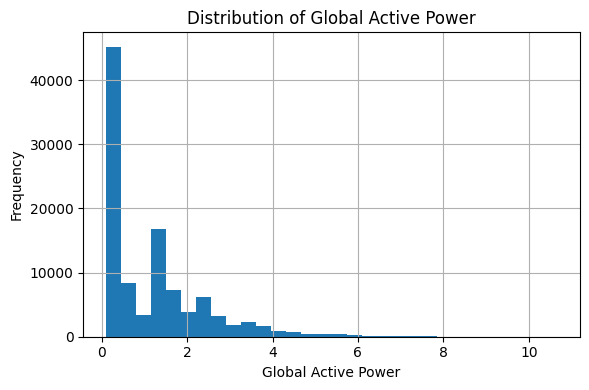

In [8]:
#   d) Distribution histogram
plt.figure(figsize=(6, 4))
df['Global_active_power'].hist(bins=30)
plt.title('Distribution of Global Active Power')
plt.xlabel('Global Active Power')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


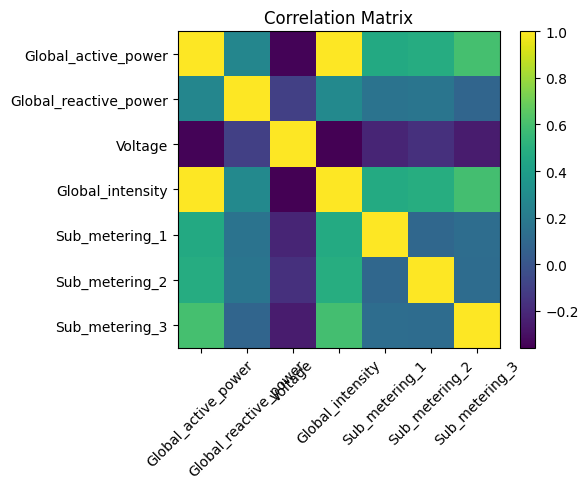

In [9]:
#   e) Correlation matrix heatmap
corr = df[numeric_cols].corr()
plt.figure(figsize=(6, 5))
plt.imshow(corr, interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.index)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

As the corelation between Global_active_power and Global_intensity is near to 1, we are dropping Global_Intensity


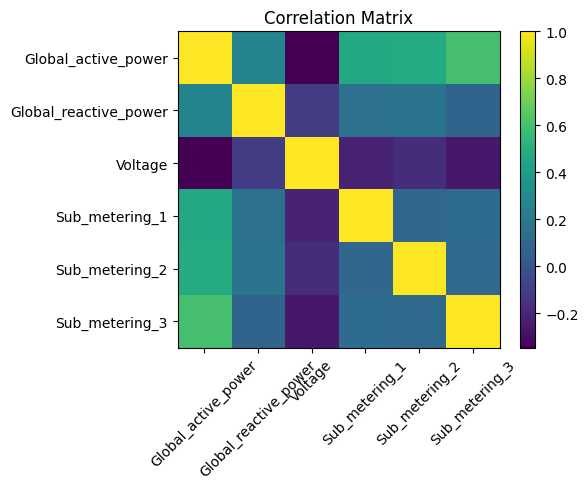

In [10]:
# f) Drop the highly-collinear column 
df.drop(columns=['Global_intensity'], inplace=True)
print("As the corelation between Global_active_power and Global_intensity is near to 1, we are dropping Global_Intensity")
# Correlation matrix heatmap after the changes
new_numeric_cols = [
    'Global_active_power','Global_reactive_power','Voltage',
    'Sub_metering_1','Sub_metering_2','Sub_metering_3'
]
corr = df[new_numeric_cols].corr()
plt.figure(figsize=(6, 5))
plt.imshow(corr, interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.index)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


In [11]:
# 7) Feature engineering
df['hour']      = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month']     = df.index.month
df['lag1']      = df['Global_active_power'].shift(1)
df['lag24']     = df['Global_active_power'].shift(24)
df['rolling_3h']= df['Global_active_power'].rolling(3, min_periods=1).mean()
df.dropna(inplace=True)



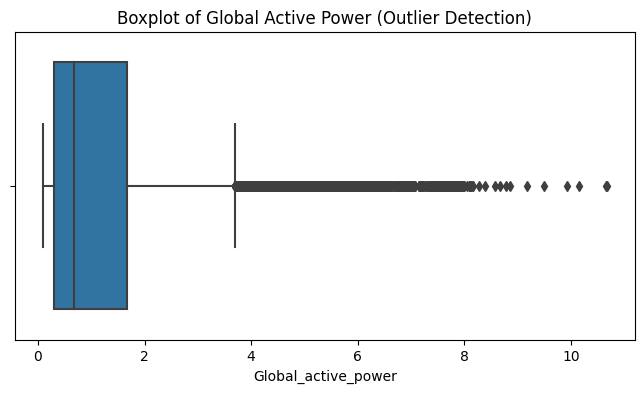

In [12]:
#Visualise Outliers
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.boxplot(x=df['Global_active_power'])
plt.title("Boxplot of Global Active Power (Outlier Detection)")
plt.show()


Explore daily, weekly, and monthly trends in the Global Active Power

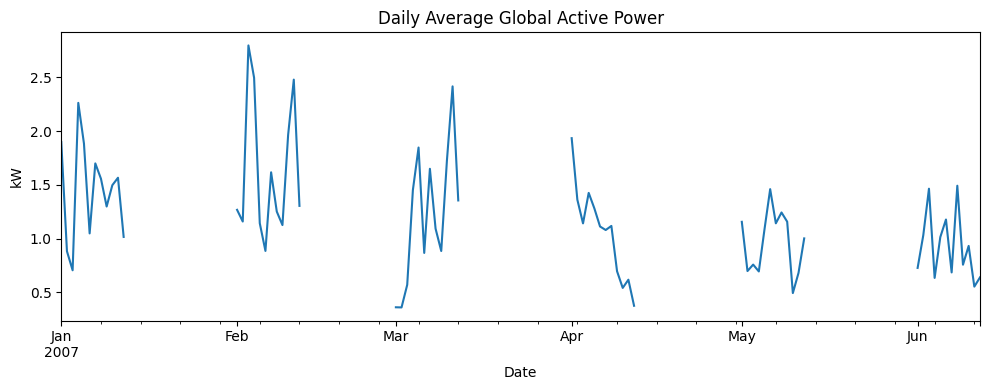

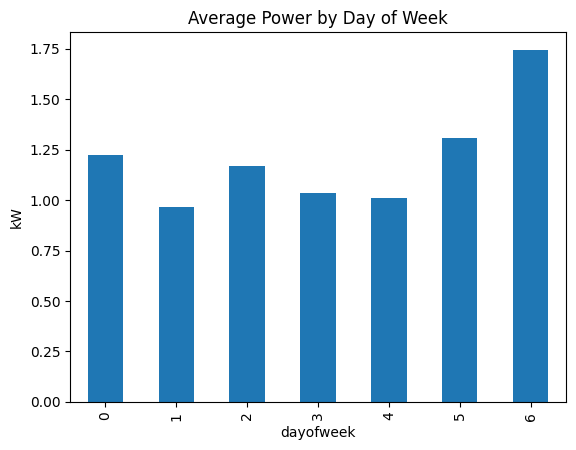

In [13]:

# Daily average
daily_avg = df['Global_active_power'].resample('D').mean()
plt.figure(figsize=(10, 4))
daily_avg.plot(title='Daily Average Global Active Power')
plt.ylabel('kW')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# Weekly patterns
df.groupby('dayofweek')['Global_active_power'].mean().plot(kind='bar', title='Average Power by Day of Week')
plt.ylabel('kW')
plt.show()


Heatmap of Usage by Hour and Day,
Useful to identify usage patterns

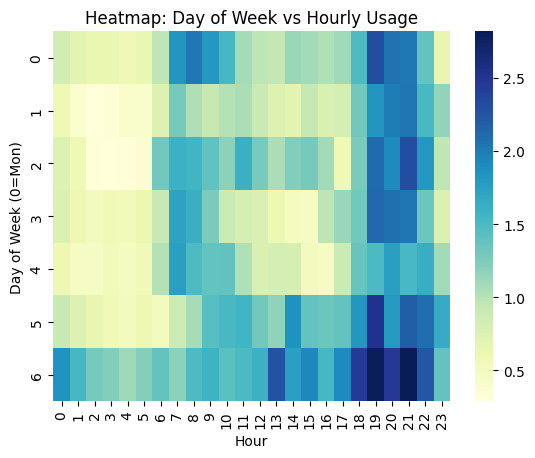

In [14]:
pivot = df.pivot_table(values='Global_active_power', index=df.index.dayofweek, columns=df.index.hour, aggfunc='mean')
sns.heatmap(pivot, cmap='YlGnBu')
plt.title("Heatmap: Day of Week vs Hourly Usage")
plt.xlabel("Hour")
plt.ylabel("Day of Week (0=Mon)")
plt.show()


Autocorrelation and Partial Autocorrelation to
Visualize how past values influence current values

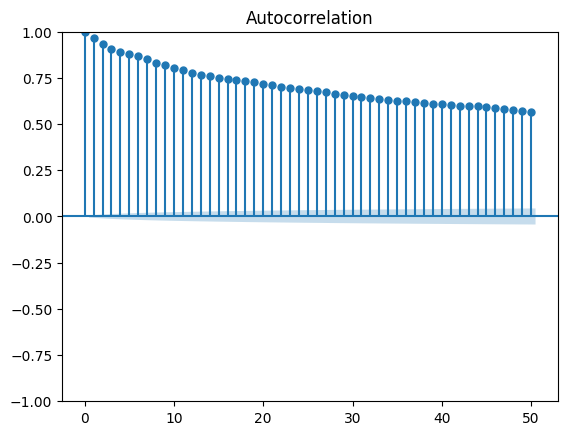

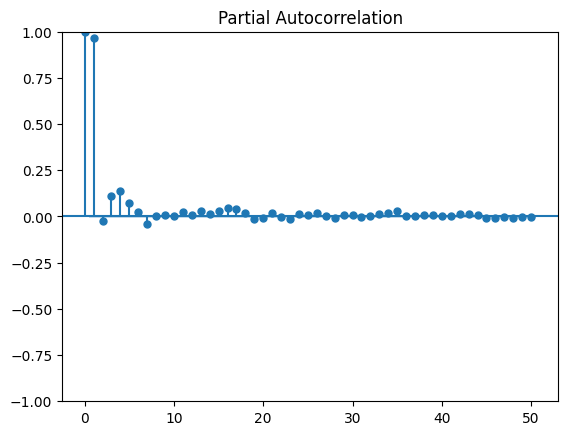

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Global_active_power'], lags=50)
plt.title('Autocorrelation')
plt.show()

plot_pacf(df['Global_active_power'], lags=50)
plt.title('Partial Autocorrelation')
plt.show()


In [16]:
#Scaling
scaler = StandardScaler()
features = [
    'Global_reactive_power','Voltage',
    # 'Global_intensity',    # ← dropped
    'Sub_metering_1','Sub_metering_2','Sub_metering_3',
    'hour','dayofweek','month','lag1','lag24','rolling_3h'
]
df[features] = scaler.fit_transform(df[features])

In [17]:
df.to_csv("cleaned_power_data.csv")


In [18]:
target = 'Global_active_power'

features = [
    'Global_reactive_power', 'Voltage',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'hour', 'dayofweek', 'month',
    'lag1', 'lag24', 'rolling_3h'
]


In [19]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df[target]

# 80/20 split without shuffling
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]


In [20]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


MAE: 0.0651
RMSE: 0.1813


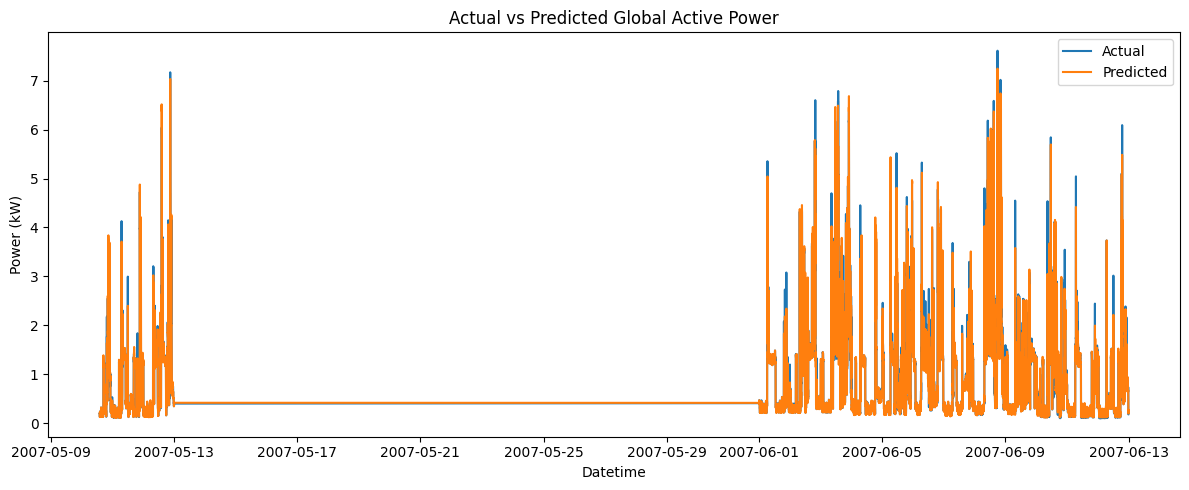

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title('Actual vs Predicted Global Active Power')
plt.xlabel('Datetime')
plt.ylabel('Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

gbr.fit(X_train, y_train)


GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred_gbr = gbr.predict(X_test)

mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))

print(f"Gradient Boosting MAE: {mae_gbr:.4f}")
print(f"Gradient Boosting RMSE: {rmse_gbr:.4f}")


Gradient Boosting MAE: 0.0696
Gradient Boosting RMSE: 0.1722


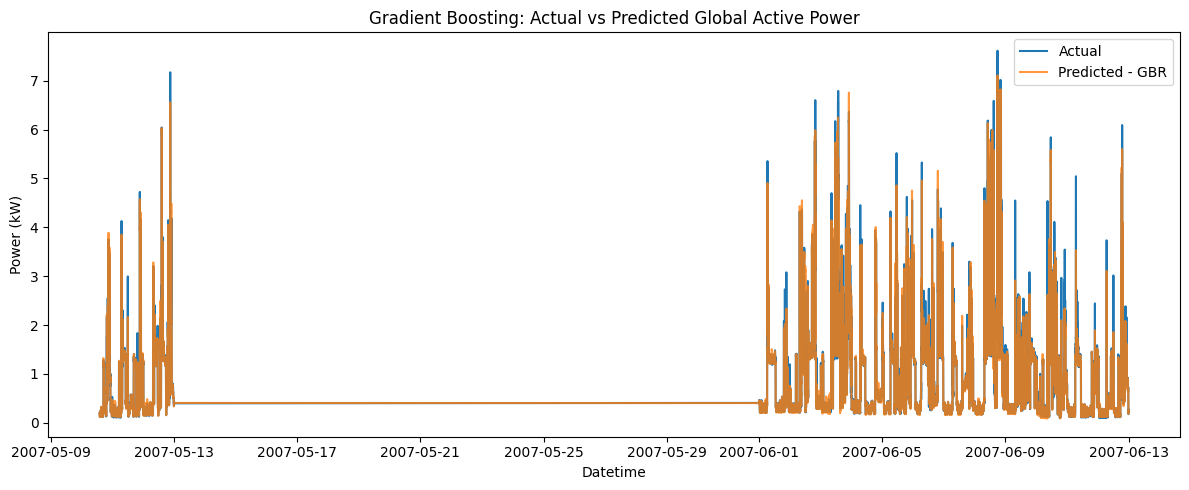

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_gbr, label='Predicted - GBR', alpha=0.8)
plt.title('Gradient Boosting: Actual vs Predicted Global Active Power')
plt.xlabel('Datetime')
plt.ylabel('Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()


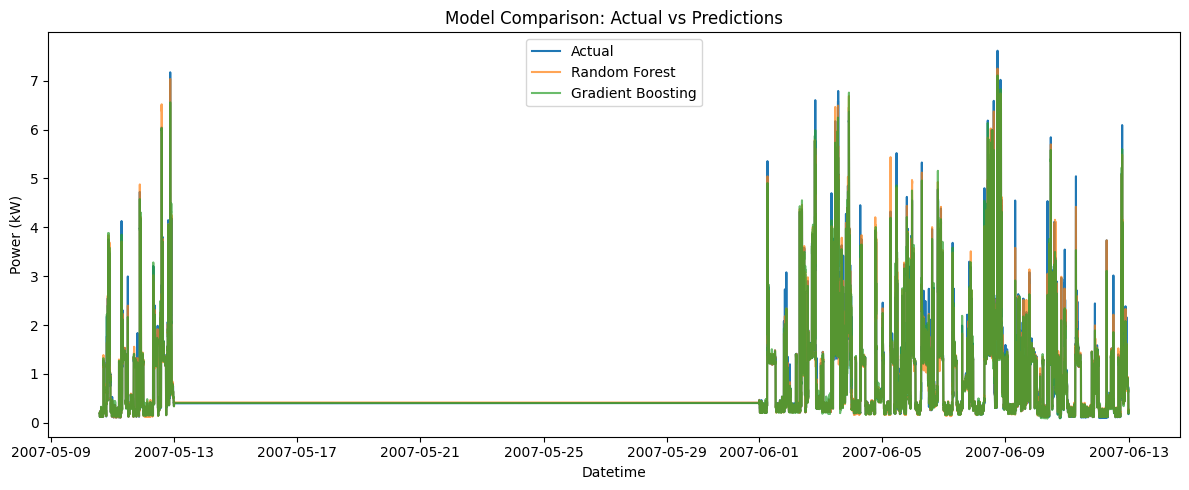

In [26]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Random Forest', alpha=0.7)
plt.plot(y_test.index, y_pred_gbr, label='Gradient Boosting', alpha=0.7)
plt.title('Model Comparison: Actual vs Predictions')
plt.xlabel('Datetime')
plt.ylabel('Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()


In [27]:
import xgboost as xgb
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'
)

xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost MAE: {mae_xgb:.4f}")
print(f"XGBoost RMSE: {rmse_xgb:.4f}")


XGBoost MAE: 0.0736
XGBoost RMSE: 0.1737


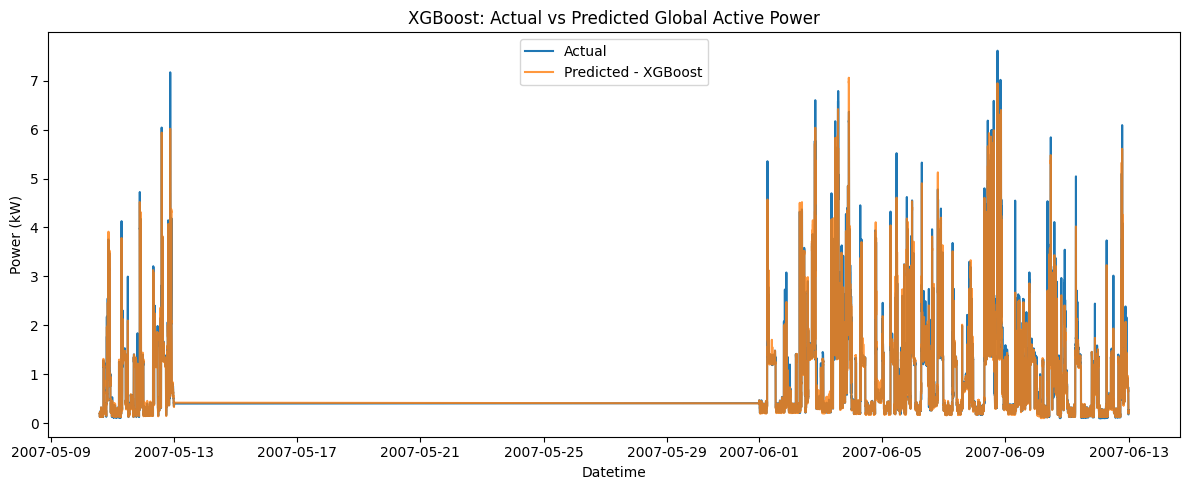

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_xgb, label='Predicted - XGBoost', alpha=0.8)
plt.title('XGBoost: Actual vs Predicted Global Active Power')
plt.xlabel('Datetime')
plt.ylabel('Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()


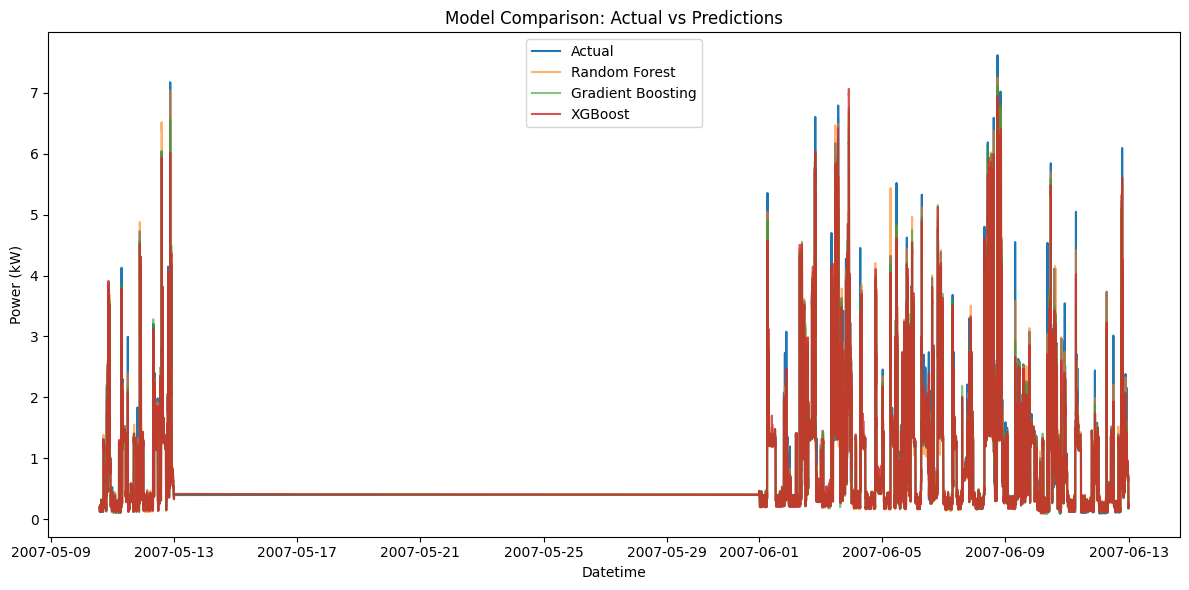

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Random Forest', alpha=0.6)
plt.plot(y_test.index, y_pred_gbr, label='Gradient Boosting', alpha=0.6)
plt.plot(y_test.index, y_pred_xgb, label='XGBoost', alpha=0.8)
plt.title('Model Comparison: Actual vs Predictions')
plt.xlabel('Datetime')
plt.ylabel('Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()


In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')


In [32]:
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_params,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)
print("Best Random Forest Params:", rf_grid.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Random Forest Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


In [33]:
gbr_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

gbr_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    gbr_params,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

gbr_grid.fit(X_train, y_train)
print("Best Gradient Boosting Params:", gbr_grid.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Gradient Boosting Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}


In [34]:
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42),
    xgb_params,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train)
print("Best XGBoost Params:", xgb_grid.best_params_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best XGBoost Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


In [35]:
# Create DataFrame with predictions and datetime index
results_df = pd.DataFrame({
    'Datetime': y_test.index.to_pydatetime(),
    'Actual': y_test.values,
    'Predicted_XGBoost': y_pred_xgb
})

# Save to CSV
results_df.to_csv('xgboost_predictions.csv', index=False)

print("Predictions saved to xgboost_predictions.csv")


Predictions saved to xgboost_predictions.csv


Dynamic Pricing Schedule for Next Day (Hourly):

                 Datetime  Predicted_Load_kW  Dynamic_Price_per_kWh
0     2007-05-10 13:56:00           0.199464                   0.08
1     2007-05-10 13:57:00           0.199997                   0.08
2     2007-05-10 13:58:00           0.199997                   0.08
3     2007-05-10 13:59:00           0.194690                   0.08
4     2007-05-10 14:00:00           0.194408                   0.08
...                   ...                ...                    ...
20719 2007-06-12 23:55:00           0.191673                   0.08
20720 2007-06-12 23:56:00           0.191673                   0.08
20721 2007-06-12 23:57:00           0.191673                   0.08
20722 2007-06-12 23:58:00           0.202576                   0.08
20723 2007-06-12 23:59:00           0.243419                   0.08

[20724 rows x 3 columns]


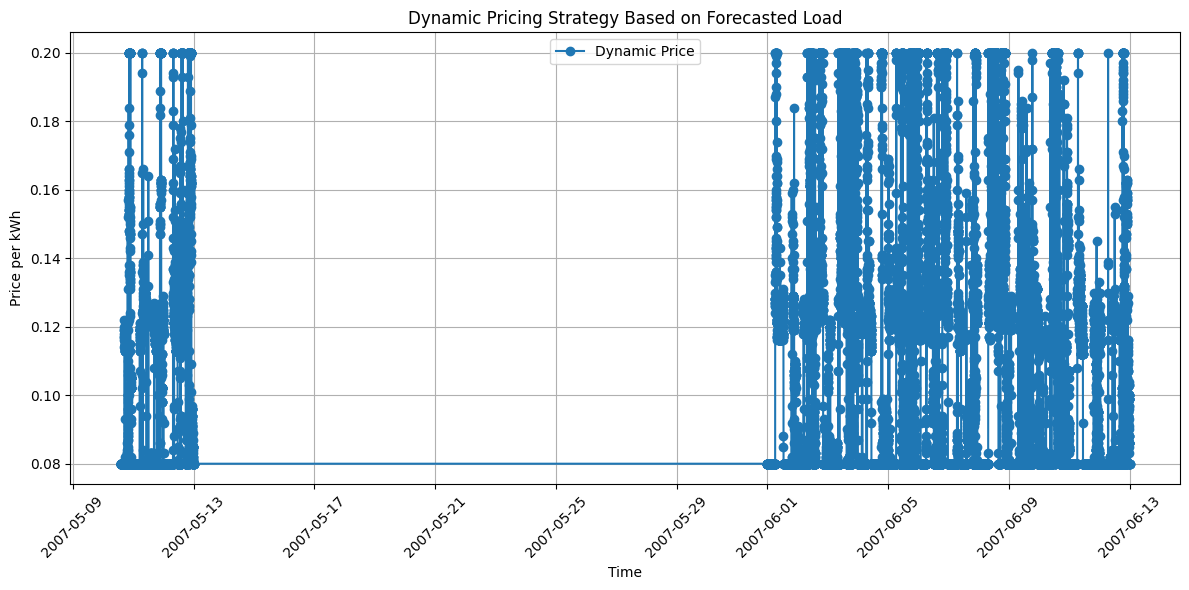

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Example Input:
# test_df['Datetime'] -> hourly timestamps for the next day (24 rows)
# y_pred -> predicted energy load (same order, 24 values)
# --------------------------

# Simulate example inputs if not already present
# Comment these if you already have actual predictions
# -----------------------------------
# test_df = pd.DataFrame({'Datetime': pd.date_range("2025-06-05", periods=24, freq='H')})
# y_pred = np.random.normal(loc=1.5, scale=0.3, size=24)
# -----------------------------------

# Convert predictions to pandas Series for convenience
predicted_demand = pd.Series(y_pred_xgb, index=results_df['Datetime'])

# --------------------------
# ✅ Dynamic Pricing Strategy Logic
# --------------------------

# Base price in ₹ or $
base_price = 0.10  # 10 cents or ₹ per kWh

# Dynamic pricing: adjust price based on demand relative to the mean
price = base_price + 0.05 * (predicted_demand - predicted_demand.mean()) / predicted_demand.std()

# Optional: cap prices between 0.08 and 0.20
price = price.clip(lower=0.08, upper=0.20)

# Build final pricing table
pricing_df = pd.DataFrame({
    'Datetime': predicted_demand.index,
    'Predicted_Load_kW': predicted_demand.values,
    'Dynamic_Price_per_kWh': price.values
})

# Format the price to 2 decimal places
pricing_df['Dynamic_Price_per_kWh'] = pricing_df['Dynamic_Price_per_kWh'].round(3)

# --------------------------
# ✅ Display the schedule
# --------------------------
print("Dynamic Pricing Schedule for Next Day (Hourly):\n")
print(pricing_df)

# Optional: plot
plt.figure(figsize=(12, 6))
plt.plot(pricing_df['Datetime'], pricing_df['Dynamic_Price_per_kWh'], marker='o', label='Dynamic Price')
plt.title("Dynamic Pricing Strategy Based on Forecasted Load")
plt.xlabel("Time")
plt.ylabel("Price per kWh")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

📅 Schedule your energy-intensive task in the following hours:

                 Datetime  Predicted_Load_kW  Dynamic_Price_per_kWh
0     2007-05-10 13:56:00           0.199464                   0.08
12175 2007-06-07 00:53:00           0.289761                   0.08
12176 2007-06-07 00:54:00           0.247844                   0.08


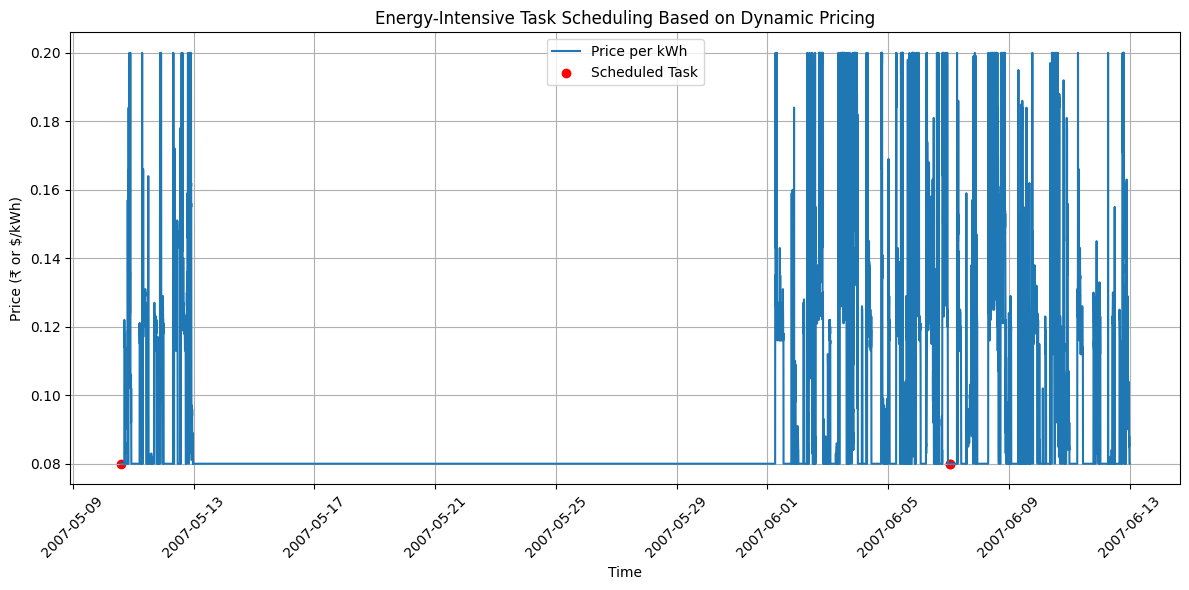

In [43]:

import pandas as pd
import numpy as np



# ✅ Number of hours needed for the task
task_duration = 3  # e.g., run industrial machine for 3 hours

# ✅ Sort by lowest price
cheapest_slots = pricing_df.sort_values('Dynamic_Price_per_kWh').head(task_duration)

# ✅ Schedule tasks in these hours
print("📅 Schedule your energy-intensive task in the following hours:\n")
print(cheapest_slots[['Datetime', 'Predicted_Load_kW', 'Dynamic_Price_per_kWh']])

# Optional: visual summary
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(pricing_df['Datetime'], pricing_df['Dynamic_Price_per_kWh'], label='Price per kWh')
plt.scatter(cheapest_slots['Datetime'], cheapest_slots['Dynamic_Price_per_kWh'], color='red', label='Scheduled Task')
plt.title("Energy-Intensive Task Scheduling Based on Dynamic Pricing")
plt.xlabel("Time")
plt.ylabel("Price (₹ or $/kWh)")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [44]:
import pandas as pd
import numpy as np



# Set thresholds based on your system or historical average
threshold_high = pricing_df['Predicted_Load_kW'].mean() + 0.5 * pricing_df['Predicted_Load_kW'].std()
threshold_low = pricing_df['Predicted_Load_kW'].mean() - 0.5 * pricing_df['Predicted_Load_kW'].std()

# Apply balancing strategy
print("🔧 Grid Load Balancing Strategy for Next Day:\n")

for _, row in pricing_df.iterrows():
    time = row['Datetime']
    load = row['Predicted_Load_kW']

    if load > threshold_high:
        print(f"{time}: ⚠️ HIGH demand ({load:.2f} kW) → Dispatch batteries / reduce EV charging.")
    elif load < threshold_low:
        print(f"{time}: ✅ LOW demand ({load:.2f} kW) → Schedule battery charging / maintenance.")
    else:
        print(f"{time}: 🔄 NORMAL demand ({load:.2f} kW) → Standard grid operations.")

🔧 Grid Load Balancing Strategy for Next Day:

2007-05-10 13:56:00: ✅ LOW demand (0.20 kW) → Schedule battery charging / maintenance.
2007-05-10 13:57:00: ✅ LOW demand (0.20 kW) → Schedule battery charging / maintenance.
2007-05-10 13:58:00: ✅ LOW demand (0.20 kW) → Schedule battery charging / maintenance.
2007-05-10 13:59:00: ✅ LOW demand (0.19 kW) → Schedule battery charging / maintenance.
2007-05-10 14:00:00: ✅ LOW demand (0.19 kW) → Schedule battery charging / maintenance.
2007-05-10 14:01:00: ✅ LOW demand (0.17 kW) → Schedule battery charging / maintenance.
2007-05-10 14:02:00: ✅ LOW demand (0.15 kW) → Schedule battery charging / maintenance.
2007-05-10 14:03:00: ✅ LOW demand (0.13 kW) → Schedule battery charging / maintenance.
2007-05-10 14:04:00: ✅ LOW demand (0.13 kW) → Schedule battery charging / maintenance.
2007-05-10 14:05:00: ✅ LOW demand (0.13 kW) → Schedule battery charging / maintenance.
2007-05-10 14:06:00: ✅ LOW demand (0.13 kW) → Schedule battery charging / maintenanc